# Training a Gunshot detection model with `opensoundscape`

The versionning of the old project renders its use impractical today. `opensoundscape (v0.5.0)` is at the heart of the previous pipeline. However, using this version today is incompatible with other libaries such as `torch`, whose changes removed elements that made it compatible with the previous pipeline. Instead of recreating an old versioning for this model, I chose to recreate the pipeline with current libraries. This should allow for state-of-the-art edits to further improve the model, and pursue projects in line with my distillation project. 

## Environment setup

In [1]:
# Machine Learning imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import resnet18

# Opensoundscape imports
from opensoundscape import AudioFileDataset, SpectrogramPreprocessor
from opensoundscape.ml.utils import collate_audio_samples_to_tensors
from opensoundscape.preprocess.utils import show_tensor_grid
from opensoundscape import data_selection

# Processing imports
import os
import numpy as np

# Import from common to avoid redundancies between notebooks
from utils.common import list_files, create_dataframe, train_model, evaluate_model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch in {device} mode")

MODEL_DIR = "models"
BUCKET_NAME = "gunshot-data"
TRAIN_PREFIX = "Data/Training data"
VAL_PREFIX   = "Data/Validation data"

PyTorch in cpu mode


In the following cell, define the training parameters. 
More about choosing a batch size for ResNet [here](https://nikita.melkozerov.dev/posts/transfer-learning-batch-size-experiment/)

In [3]:
batch_size = 128
num_workers = 8 if str(device) == "cuda" else 2
num_epochs = 20
lr = 0.001

## Data Loading

In [4]:
train_keys = list_files(TRAIN_PREFIX)
val_keys   = list_files(VAL_PREFIX)

# Using a df allows us to introduce labels in the AudioFileDataset
train_df   = create_dataframe(train_keys)
val_df     = create_dataframe(val_keys)

# We also upsample the minority class
train_df_upsampled = data_selection.upsample(train_df, label_column="label")

print(f"Found {len(train_keys)} training audios, {len(val_keys)} validation audios.")
print(f"Upsampled dataset has {len(train_df_upsampled)} training audios.")

Found 28790 training audios, 7190 validation audios.
Upsampled dataset has 56386 training audios.


Initializing the Audio dataset and the preprocessor using `opensoundscape`. 

Here, we copy out the preprocessing that was done in the original paper, which can be found [here](https://github.com/lydiakatsis/tropical_forest_gunshot_classifier/blob/main/Model%20and%20code/train_GUNSHOT_classifier.py)

In [5]:
train_preprocessor = SpectrogramPreprocessor(sample_duration=4.0)
train_preprocessor.pipeline.random_affine.set(translate=(0.1, 0.1))
train_preprocessor.pipeline.load_audio.set(sample_rate=8000)
train_preprocessor.pipeline.frequency_mask.set(max_width=0.05, max_masks=10)
train_preprocessor.pipeline.time_mask.set(max_width=0.05, max_masks=10)
train_preprocessor.pipeline.bandpass.set(min_f=0,max_f=2000)
train_preprocessor.pipeline.to_spec.set(window_samples=256,overlap_samples=256//2)

val_preprocessor = SpectrogramPreprocessor(sample_duration=4.0)
val_preprocessor.pipeline.load_audio.set(sample_rate=8000)
val_preprocessor.pipeline.bandpass.set(min_f=0,max_f=2000)
val_preprocessor.pipeline.to_spec.set(window_samples=256,overlap_samples=256//2)

train_audio_dataset = AudioFileDataset(train_df_upsampled,train_preprocessor)

val_audio_dataset = AudioFileDataset(val_df,val_preprocessor)
val_audio_dataset.bypass_augmentations = True

In [6]:
train_loader = DataLoader(
    train_audio_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn = collate_audio_samples_to_tensors,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_audio_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn = collate_audio_samples_to_tensors,
    num_workers=num_workers,
    pin_memory=True
)

## Plotting a few examples

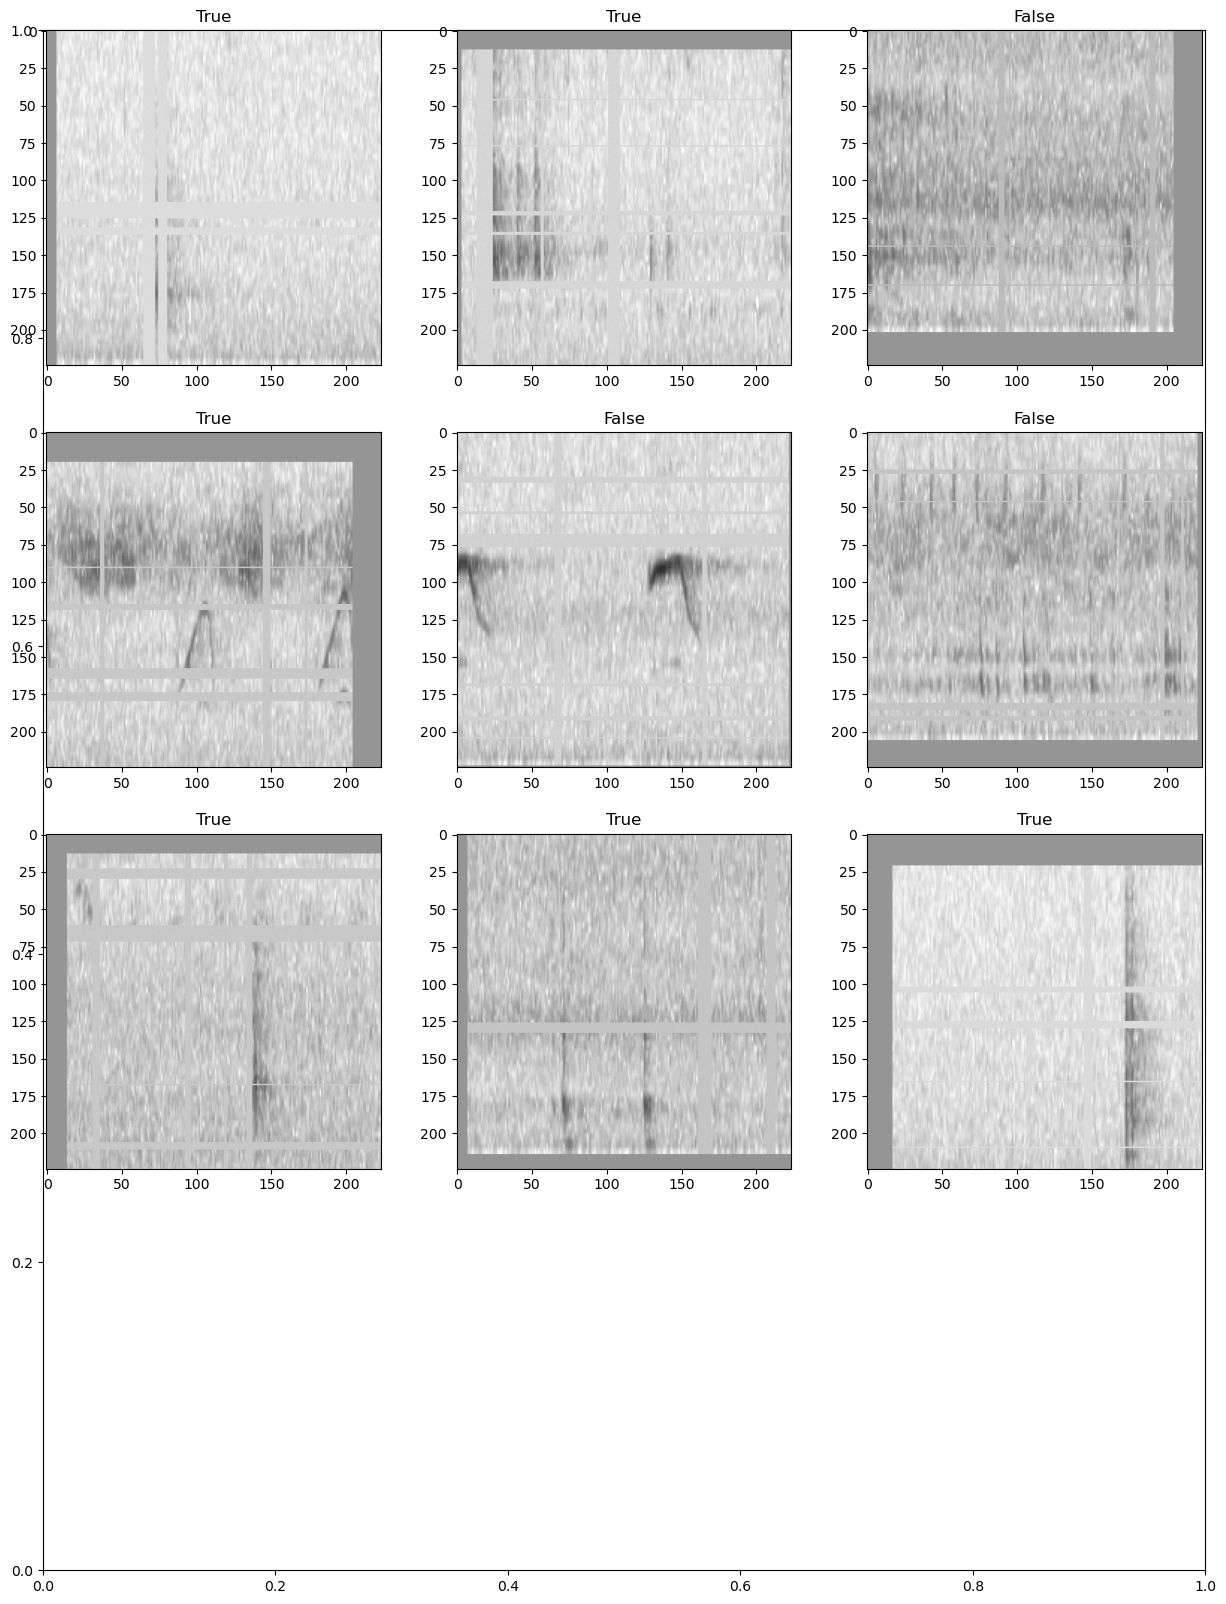

In [7]:
dataset = train_audio_dataset
tensors = [dataset[i].data for i in range(9)]
sample_labels = [dataset[int(i)].labels["label"] for i in np.random.choice(len(dataset), size=9, replace=False)]
_ = show_tensor_grid(tensors,3,labels=sample_labels)

## Training and Evaluating various models

### ResNet18

ResNet18 is well-suited for gunshot detection with spectrograms because its architecture captures hierarchical audio features while its residual connections mitigate vanishing gradients.

In [10]:
ResNet18 = resnet18(weights="IMAGENET1K_V1")
ResNet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
ResNet18.fc = nn.Linear(ResNet18.fc.in_features, 2)
ResNet18 = ResNet18.to(device)

output_path_resnet = os.path.join(MODEL_DIR, "best_resnet.pth")
output_path_resnet2 = os.path.join(MODEL_DIR, "last_resnet.pth")

In [ ]:
train_model(ResNet18, train_loader, val_loader, output_path_resnet, output_path_resnet2, num_epochs, lr)

In [16]:
evaluate_model("models/best_resnet.pth", val_loader)

Evaluating: 100%|██████████| 57/57 [00:04<00:00, 11.98it/s]



=== Classification Report ===
              precision    recall  f1-score   support

  Background       1.00      0.99      0.99      7040
     Gunshot       0.68      0.93      0.79       150

    accuracy                           0.99      7190
   macro avg       0.84      0.96      0.89      7190
weighted avg       0.99      0.99      0.99      7190


=== Performance Metrics ===
Accuracy: 0.9896
Precision: 0.6847
Recall: 0.9267
F1 Score: 0.7875

✅ Evaluation complete. Results saved in: evaluation/Run_20250303-1123
